# Processing OISST Data with Python 3.6 & Local Netcdf Files

## Product 1. Global Daily Climatology

**ABOUT:**
In many cases when dealing with questions surrounding changes in climate it is beneficial to work in units of temperature anomalies rather than actual temperature measurements. For the purposes of our work with the OISST dataset that involves creating a 30-year climatology using temperature observations for 1982-2011. The climatology conntains the mean sea surface temperature observation for each day of the year and at each cell. As an example, the first time step in the climatology is for January 1st. The values in each cell for that time step is the mean sea surface temperature from January 1st of every year from 1982 to 2011. One distinction about the climatology processing done within this notebook is that the day of year has been modified to honor the presence or absence of leap days occurring on Feb. 29th. Done this way, March 1st is always the 60th day and all days following it maintain the same modified day of the year. This allows us to truly compare the values of calendar dates directly to what those calendar dates were historically without them shifting each time it is a leap year.


**NOTE: This Notebook only needs to be updated if/when there is a desire to use a different reference period for the climatology.**

Files containing daily observations for global sea surface temperature are pre-downloaded for analyses using links at this directory: [NOAA Physical Sciences Laboratory](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html). These files are stored on Box in the `Box/NSF OKN Demo Data` folder.

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os

#ensure we're in correct directory/volume
#os.chdir("/home/jovyan/NSF OKN Demo Data/oisst/annual_observations") #when working in nsf okn folder
os.chdir("RES_Data/OISST/oisst_mainstays/annual_observations") 

#Suppress divide by NA error that occurs when getting mean from array
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Step 1: Load Pre-downloaded OISSTv2 netcdf files

As currently written this workflow does not have continuous integration of new data. All the annual files have been pre-downloaded from the links above and stored together in the same folder in box. Step 1 of calculating the climatology for the reference period is to access the files for the reference period we are interested in.

For the the 30-year climatology the starting year is 1982, since that is the first full year available. We will need to load all years from there for through 2011 with the climatology period ending with December of 2011. Each pre-downloaded file follows the same naming structure so we can populate a list of file names by iterating over the years we wish to use as the reference period for the climatology.

In [2]:
# Set start and end year for climatology
start_year = 1982
end_year = 2011

#Generate list of file names from start and end + 1
my_years = np.arange(start_year, (end_year + 1), 1)
   
# Print Climatology Years
print("Generating Climatology for the Following Years")
print(my_years)

Generating Climatology for the Following Years
[1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011]


Next we can use those years to create the `nc_files` list, which contains all the file names for the climatology reference period. This list will then get passed to an xarray function to load and append each of them into a single array.

In [3]:
# Make List of the Corresponding File Names:
nc_files = []
for i in my_years:
    nc_files.append("sst.day.mean." + str(i) + ".v2.nc")
print(nc_files[0:6])

['sst.day.mean.1982.v2.nc', 'sst.day.mean.1983.v2.nc', 'sst.day.mean.1984.v2.nc', 'sst.day.mean.1985.v2.nc', 'sst.day.mean.1986.v2.nc', 'sst.day.mean.1987.v2.nc']


## Step 2: Open and Append Netcdf Files with xarray

xarray has tools that allow all years to be opened and lazy-loaded simultaneously and manipulated as a single dataset. Once the dataset has been appended together we can work with it as if it is a single object. The main reason we are working with xarray here is because it is better with out-of-memory processing for these large array objects

In [4]:
# If working locally its possible to paralellize the processing using dask
# As of 11/25/2020 this functionality has not been sorted out for working in the docker environment
#clim = xr.open_mfdataset('*.nc', parallel = True, combine = 'by_coords')

# Use open_mfdataset to load and append the list of oisst arrays
oisst = xr.open_mfdataset(nc_files, parallel = False, combine = "by_coords")
oisst

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 10957)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2011-12-31
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(365, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

## Step 3: Calculate Daily Climatologies

In order to calculate daily climatological means we want to first group the array data by the day of the year, then calculate the mean temperature of every cell across all years. The result is an array with a layer for every day on the year, with values that are the mean temperature that day across the 30-year reference period. 

One issue/observation here is that `ds.time.dayofyear` switches between 365 & 366 days, meaning any day from march through the end of december is going to shift by 1 every leap year. The workaround for this is to create a new index to group on that represents a leap-year adjusted day of the year year.

In [5]:
# Original day of year values, shift from 0-365 to 0-366 for leap years
oisst['sst'].groupby('time.dayofyear')

DataArrayGroupBy, grouped over 'dayofyear' 
366 groups with labels 1, 2, 3, 4, 5, ..., 363, 364, 365, 366.

## Step 4: Make New Ordinal Index for Day of Year

The way around the leap-year issue is to make a new ordinal day vector to which puts all years on the same 366 day scale ensuring that March 1st for example is always the 61st day, even on non-leap-years. This is done by adding 1 to the ordinal day for all days from March 1st onwards for years that are not leap-years.

In [6]:
# Leap year and March or later flags:
not_leap_year = ~oisst.indexes['time'].is_leap_year
march_or_later = oisst.time.dt.month >= 3
ordinal_day = oisst.time.dt.dayofyear

# Add index to dataset
modified_ordinal_day = ordinal_day + (not_leap_year & march_or_later)
modified_ordinal_day = modified_ordinal_day.rename('modified_ordinal_day')

#### Test Understanding  ####

#TRUE/FALSE to indicate that its not a leap year, and its after February
#(not_leap_year & march_or_later) 

#Output is the original ordinal day + 1 if the condition is met
#ordinal_day + (not_leap_year & march_or_later) #Adding a TRUE is the same as adding 1

## Step 5: Process Climate Means

Now use that modified ordinal day as the grouping index and calculate the mean sea surface temperature values across the global grid.

In [7]:
# Group on the modified ordinal day then get the means
daily_clims = oisst['sst'].groupby(modified_ordinal_day).mean('time', keep_attrs = True)
daily_clims

<xarray.DataArray 'sst' (modified_ordinal_day: 366, lat: 720, lon: 1440)>
dask.array<stack, shape=(366, 720, 1440), dtype=float32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.48]

## Validation: Plot a Daily Climatology
Define a function to plot a given day of the year. This will let me debug if it is actually calculating them correctly

In [8]:
# Plot Climatology for Desired Day of the Year
def plot_yearday_sst(day_year = 1):
    
    # Pull the desired day of the year
    daily_sst = daily_clims.sel(modified_ordinal_day = day_year)
    
    # Set up the figure - think about how much better ggplot2 is.
    fig = plt.figure(figsize=[12,5])
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
    fig.suptitle('Daily SST Climatology for day: ' + str(day_year) + ' of the calendar year.', fontsize=16)

    daily_sst.plot.contourf(ax=ax,
                       levels=np.arange(0, 30, 1.5),
                       extend='max',
                       transform=ccrs.PlateCarree(),
                       cbar_kwargs={'label': daily_sst.units})
    ax.coastlines()

    plt.show()

### Validation 1: Mid-year
SST Climatology for the 180th day of the year.

**NOTE:** 
Plotting takes a long time because processing of the climatology values is done as-needed. Before this step only the processing formula is recorded, nothing actually had to be calculated until now.

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


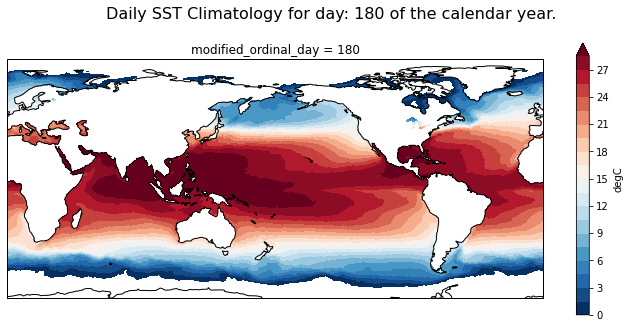

In [9]:
plot_yearday_sst(day_year = 180)

### Validation 2: Leap Year
Does it take less time to do leap years?

/Users/akemberling/opt/anaconda2/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


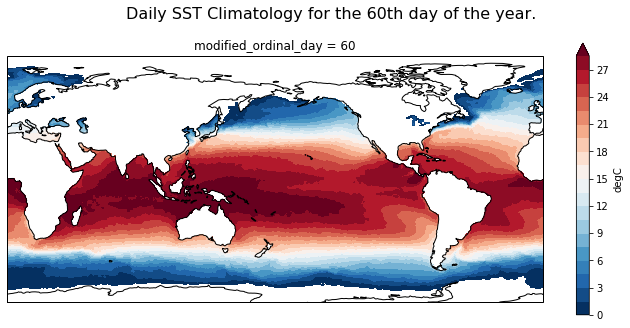

In [22]:
plot_yearday_sst(day_year = 60)

# Step 6: Exporting Daily Climatologies

Before exporting it is helpful to convert from an xarray dataarray to an xarray dataset. This allows us to add additional dimensions to the array that share common dimensions, things like temperature anomalies values. Another act of kindness is to update the metadata that will go with the file so that people using it will know its origins.

`daily_clims` is currently of type "DataArray". We want to convert it to a DataArray Dataset. DataArray Datasets are dict-like containers of labeled arrays (DataArray objects) with aligned dimensions. It is designed as an in-memory representation of the data model from the netCDF file format.

In this example there is only one variable `sst`, which we will want to change to make sure the attributes accurately describe it as a climatology.

## Accessing metadata information

The xarray dataset contains information on the array stored as attributes. Additionally, it is possible to add attributes detailing each variable as well.

In [15]:
#Note that the attributes exist here.
daily_clims.attrs

{'long_name': 'Daily Sea Surface Temperature',
 'units': 'degC',
 'valid_range': array([-3., 45.], dtype=float32),
 'precision': 2.0,
 'dataset': 'NOAA High-resolution Blended Analysis',
 'var_desc': 'Sea Surface Temperature',
 'level_desc': 'Surface',
 'statistic': 'Mean',
 'parent_stat': 'Individual Observations',
 'actual_range': array([-1.8 , 34.48], dtype=float32)}

<hr>

# Extension:

### Building xarray Dataset



In [17]:
#Make dataarray dataset to then adjust attributes
daily_clims_ds = daily_clims.to_dataset()

## Adding/Modifying Attributes
Attributes are added using dictionaries that serve as metadata for the array datasets. The current dataarray dataset structure does not contain attributes so we'll need to add them

In [20]:
#Data Array Dataset Attributes
daily_clims_ds.attrs

{}

In [22]:
# Attributes from the original OISST data
oisst.attrs

{'Conventions': 'CF-1.5',
 'title': 'NOAA High-resolution Blended Analysis: Daily Values using AVHRR only',
 'institution': 'NOAA/NCDC',
 'source': 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
 'comment': 'Reynolds, et al., 2007: Daily High-Resolution-Blended Analyses for Sea Surface Temperature. J. Climate, 20, 5473-5496.  Climatology is based on 1971-2000 OI.v2 SST, Satellite data: Navy NOAA17 NOAA18 AVHRR, Ice data: NCEP ice.',
 'history': 'Thu Aug 24 13:35:47 2017: ncatted -O -a References,global,d,, sst.day.mean.1982.v2.nc\nVersion 1.0',
 'references': 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'NOAA Daily Optimum Interpolation Sea Surface Temperature'}

In [33]:
#Change the Attributes for the dataset
daily_clims_ds.attrs['title']         = '30-Year sea surface temperature climatology from NOAA OISSTv2 SST Data'
daily_clims_ds.attrs['institution']   = 'Gulf of Maine Research Institute'
daily_clims_ds.attrs['source']        = 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/'
daily_clims_ds.attrs['comment']       = f'Climatologies represent mean SST for the years {start_year}-{end_year}'
daily_clims_ds.attrs['history']       = 'Climatologies calculated 3/2/2020'
daily_clims_ds.attrs['references']    = 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html'
daily_clims_ds.attrs['dataset_title'] = 'GMRI 30-Year Climatology - OISST'
daily_clims_ds.attrs

{'title': '30-Year sea surface temperature climatology from NOAA OISST SST ata',
 'institution': 'Gulf of Maine Research Institute',
 'source': 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
 'comment': 'Climatologies represent mean SST for the years 1982-2011',
 'history': 'Climatologies calculated 3/2/2020',
 'references': 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'GMRI 30-Year Climatology - OISST'}

In [46]:
# Attributes for individual variables
daily_clims_ds['sst'].attrs

# # These come from the Attributes of the daily_clims array
# daily_clims.attrs

{'long_name': 'Daily Sea Surface Temperature',
 'units': 'degC',
 'valid_range': array([-3., 45.], dtype=float32),
 'precision': 2.0,
 'dataset': 'NOAA High-resolution Blended Analysis',
 'var_desc': 'Sea Surface Temperature',
 'level_desc': 'Surface',
 'statistic': 'Mean',
 'parent_stat': 'Individual Observations',
 'actual_range': array([-1.8 , 34.48], dtype=float32)}

## Save to Disk
Now that the attributes/metadata is set, we just need to save them to disk

In [45]:
# Docker Volume Export Path
daily_clims_ds.to_netcdf(f'/home/jovyan/RES_Data/OISST/oisst_mainstays/daily_climatologies/daily_clims_{start_year}to{end_year}.nc')